<a href="https://colab.research.google.com/github/frctlprdx/CNN-Text-Classification/blob/main/Klasifikasi_Pesan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Import data

In [ ]:
# EDA

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter

# NLP

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

# ML
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

transfilepath = '/content/drive/My Drive/translated_spam.csv'
smsfilepath = '/content/drive/My Drive/spam_sms.csv'

#dataset Kaggle
trans_df = pd.read_csv(transfilepath)
#dataset Pribadi
sms_df = pd.read_csv(smsfilepath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trans_df.columns

Index(['Pesan', 'Kategori'], dtype='object')

In [ ]:
sms_df.columns

Index(['teks', 'label'], dtype='object')

## 1.1. Visualisasikan Data

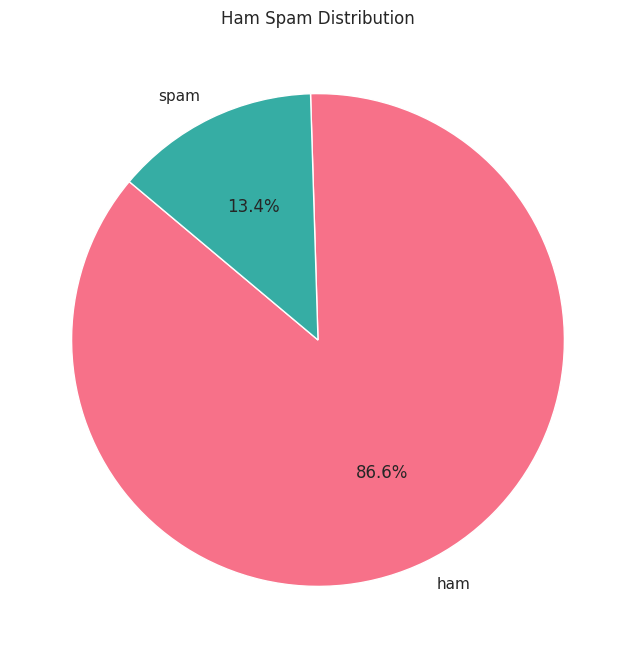

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

label_counts = trans_df['Kategori'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Ham Spam Distribution')
plt.show()

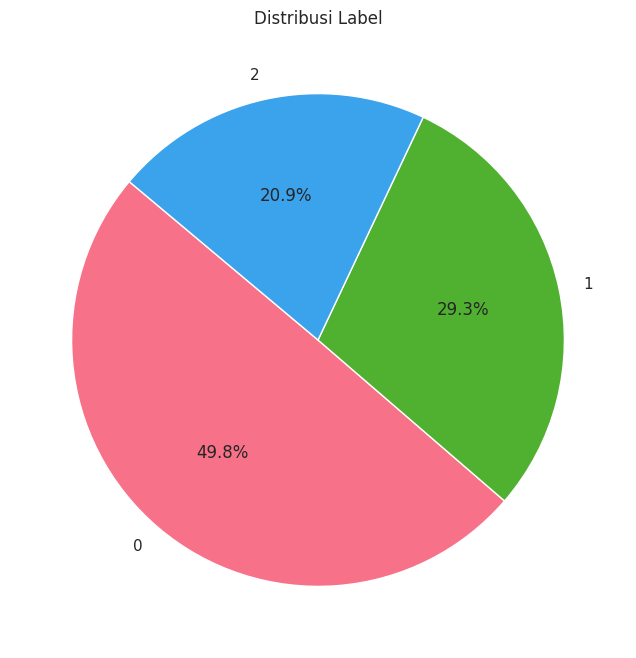

In [ ]:
label_counts = sms_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Distribusi Label')
plt.show()

# 2.Preprocessing data

In [ ]:
!pip install wordcloud xgboost imbalanced-learn

## 2.1. Mulai Preprocessing data

In [ ]:
#import library yang dibutuhkan
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
sms_df = sms_df.rename(columns={'teks': 'Pesan', 'label': 'Kategori'})
sms_df['Kategori'] = sms_df['Kategori'].replace(2, 0)

In [ ]:
trans_df['Kategori'] = trans_df['Kategori'].map({'ham': 0, 'spam': 1})

In [ ]:
final_df = pd.concat([trans_df, sms_df], ignore_index=True)

In [ ]:
final_df

,Pesan,Kategori
0,"Pergi sampai jurong point, gila.. Hanya tersed...",0
1,Ok lar... Bercanda denganmu oni...,0
2,Entri gratis dalam 2 minggu berturut-turut unt...,1
3,"Kamu tidak bilang pagi-pagi sekali, hor... Kam...",0
4,"Tidak, menurutku dia tidak pergi ke usf, dia t...",0
...,...,...
6710,"Yooo sama2, oke nanti aku umumin di grup kelas",0
6711,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0
6712,Mba mau kirim 300 ya,0
6713,nama1 beaok bwrangkat pagi...mau cas atay tra...,0


In [ ]:
#Function untuk membersihkan text

def convert_to_lower(text):
    return text.lower()
def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

import string
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("indonesian"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

In [ ]:
#Mengisi data NaN
final_df['Pesan'] = final_df['Pesan'].fillna(method='ffill')

In [ ]:
#Mengubah teks menjadi lowecase
final_df['text_clean'] = final_df['Pesan'].apply(lambda x: convert_to_lower(x))

#Menghilangkan nomor di pesan
final_df['text_clean'] = final_df['text_clean'].apply(lambda x: remove_numbers(x))

#Menghilangkan tanda baca
final_df['text_clean'] = final_df['text_clean'].apply(lambda x: remove_punctuation(x))

#Menghilangkan stopwords
final_df['text_clean'] = final_df['text_clean'].apply(lambda x: remove_stopwords(x))

#Menghilangkan extra spasi yang tidak diperlukan
final_df['text_clean'] = final_df['text_clean'].apply(lambda x: remove_extra_white_spaces(x))

#Proses lematisasi
final_df['text_clean'] = final_df['text_clean'].apply(lambda x: lemmatizing(x))

#Hitung teks setelah dibersihkan
final_df['length_after_cleaning'] = final_df['text_clean'].apply(lambda x: len(x))

In [ ]:
#Membuat data ke CSV
final_df.to_csv('cleaned_data.csv', index=False)

In [ ]:
final_df

,Pesan,Kategori,text_clean,length_after_cleaning
0,"Pergi sampai jurong point, gila.. Hanya tersed...",0,pergi jurong point gila tersedia bugis great w...,85
1,Ok lar... Bercanda denganmu oni...,0,ok lar bercanda denganmu oni,28
2,Entri gratis dalam 2 minggu berturut-turut unt...,1,entri gratis minggu berturutturut memenangkan ...,127
3,"Kamu tidak bilang pagi-pagi sekali, hor... Kam...",0,bilang pagipagi hor bilang,26
4,"Tidak, menurutku dia tidak pergi ke usf, dia t...",0,menurutku pergi usf tinggal,27
...,...,...,...,...
6710,"Yooo sama2, oke nanti aku umumin di grup kelas",0,yooo oke umumin grup kelas,26
6711,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,😁 ga ad nulis kerudung kirain warna jins,40
6712,Mba mau kirim 300 ya,0,mba kirim ya,12
6713,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,nama beaok bwrangkat pagimau ca atay tranfer,44


## 2.2. Visualisasi data setelah preprocessing

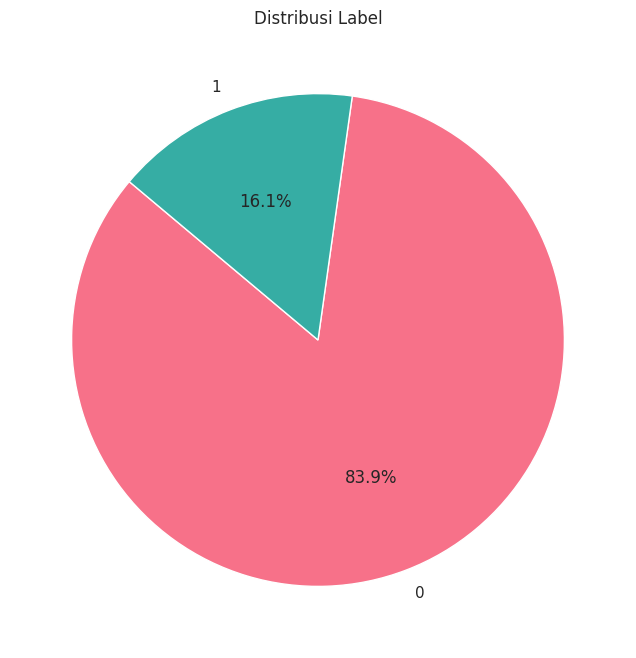

In [ ]:
label_counts = final_df['Kategori'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Distribusi Label')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_wb= TfidfVectorizer()
X_tf = tf_wb.fit_transform(final_df['text_clean'])
X_tf = X_tf.toarray()

In [ ]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, final_df['Kategori'].values, test_size=0.2)

In [ ]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train_tf, y_train_tf)
NB_pred= NB.predict(X_test_tf)
print(NB_pred)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test_tf, NB_pred))

[0 1 0 ... 0 0 0]
0.8339538346984363


In [ ]:
#Mendapatkan akurasi data 84% dengan data yang imbalance

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_df['text_clean'], final_df['Kategori'].values, test_size=0.3)

In [ ]:
from collections import Counter

Counter(y_train)

Counter({0: 3922, 1: 778})

In [ ]:
#Dapat dilihat data yang sangat imbalance

## 2.3. Oversampling data yang imbalance


In [ ]:
#Konversi data training yang sudah di vektorisasi ke bentuk array

tf_wb.fit(X_train)
X_train_transform = tf_wb.transform(X_train)
X_train_transform = X_train_transform.toarray()

In [ ]:
#Konversi data testing yang sudah di vektorisasi ke bentuk array

X_test_transform = tf_wb.transform(X_test)
X_test_transform = X_test_transform.toarray()

In [ ]:
ROS = RandomOverSampler(sampling_strategy=1)

In [ ]:
X_train_ros, y_train_ros = ROS.fit_resample(X_train_transform, y_train)

Counter(y_train_ros)

Counter({0: 3922, 1: 3922})

In [ ]:
#Kita sudah oversampling agar data balance

## 2.4. Test akurasi data yang sudah balance (menggunakan GaussianNB)

In [ ]:
NB.fit(X_train_ros, y_train_ros)
y_predict = NB.predict(X_test_transform)
y_predict

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
print(accuracy_score(y_test, y_predict))

0.8387096774193549


In [ ]:
#Masih mendapatkan akurasi data yang sama yaitu 84%

## 2.5. Oversample menggunakan berbagai algoritma

In [ ]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE , ADASYN,SVMSMOTE,KMeansSMOTE,BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced

In [ ]:
#Function untuk tes akurasi

def run_model(X,y,model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
    print(Counter(y_train))
    vectorizer_smote = TfidfVectorizer()
    vectorizer_smote.fit(X_train)
    #Vectorizing the X_train
    X_train_vec = vectorizer_smote.transform(X_train)
    X_train_vec = X_train_vec.toarray()
    #Vectorizing the X_test
    X_test_vec = vectorizer_smote.transform(X_test)
    X_test_vec = X_test_vec.toarray()
    # transform the dataset
    oversample = model
    X_train_over, y_train_over = oversample.fit_resample(X_train_vec, y_train)
    print(Counter(y_train_over))
    nb = GaussianNB()
    nb.fit(X_train_over, y_train_over)
    y_preds = nb.predict(X_test_vec)
    score = accuracy_score(y_test,y_preds)
    print("Accuracy: ",score)
    #target_names = ['class 0', 'class 1']
    #print(classification_report_imbalanced(y_test, y_preds,     target_names=target_names))
    return score

In [ ]:
#Buat variabel untuk testing

X=final_df['text_clean']
y=final_df['Kategori'].values

### 2.5.1. Menggunakan RandomOverSampler

In [ ]:
oversample= RandomOverSampler(sampling_strategy=1)
ov1=run_model(X,y,model=oversample)

Counter({0: 3944, 1: 756})
Counter({0: 3944, 1: 3944})
Accuracy:  0.8267990074441688


### 2.5.2. Menggunakan SMOTE

In [ ]:
oversample=SMOTE(sampling_strategy=1)
ov2=run_model(X,y,model=oversample)

Counter({0: 3934, 1: 766})
Counter({0: 3934, 1: 3934})
Accuracy:  0.8575682382133996


### 2.5.3. Menggunakan ADASYN

In [ ]:
oversample = ADASYN()
ov3=run_model(X,y,model=oversample)

Counter({0: 3933, 1: 767})
Counter({1: 3988, 0: 3933})
Accuracy:  0.8367245657568239


### 2.5.4. Menggunakan KMeansSMOTE

In [ ]:
oversample=KMeansSMOTE(cluster_balance_threshold=0.5)
ov4=run_model(X,y,model=oversample)

Counter({0: 3932, 1: 768})


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Counter({1: 3932, 0: 3932})
Accuracy:  0.8580645161290322


### 2.5.5. Menggunakan BorderlineSMOTE

In [ ]:
oversample=BorderlineSMOTE()
ov5=run_model(X,y,model=oversample)

Counter({0: 3969, 1: 731})
Counter({0: 3969, 1: 3969})
Accuracy:  0.8555831265508684


### 2.5.6. Menggunakan SMOTEENN

In [ ]:
oversample=SMOTEENN()
ov6=run_model(X,y,model=oversample)

Counter({0: 3954, 1: 746})
Counter({0: 3924, 1: 3873})
Accuracy:  0.8367245657568239


### 2.5.7. Menggunakan SVMSMOTE

In [ ]:
oversample=SVMSMOTE()
ov7=run_model(X,y,model=oversample)

Counter({0: 3940, 1: 760})
Counter({0: 3940, 1: 3940})
Accuracy:  0.8367245657568239


,Model,Accuracy_score
3,KMeans-SMOTE,0.858065
1,SMOTE,0.857568
4,Borderline-SMOTE,0.855583
2,ADASYN,0.836725
5,SMOTE-ENN,0.836725
0,RandomOverSampler,0.826799


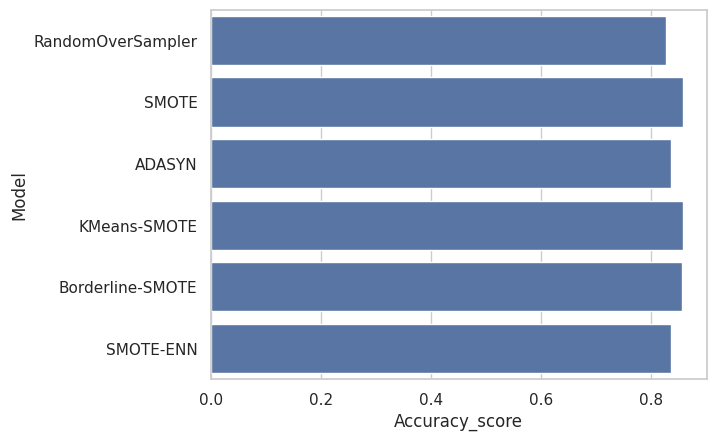

In [ ]:
over_models = pd.DataFrame({
    'Model':['RandomOverSampler',
             'SMOTE',
             'ADASYN',
             'KMeans-SMOTE',
             'Borderline-SMOTE',
             'SMOTE-ENN'
            ],
    'Accuracy_score' :[ov1 ,ov2, ov3, ov4,ov5,ov6
                      ]
})
sns.barplot(x='Accuracy_score', y='Model', data=over_models)
over_models.sort_values(by='Accuracy_score', ascending=False)

# 3.Membuat model CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_df['text_clean'], final_df['Kategori'].values, test_size=0.3)

In [ ]:
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [ ]:
BS = BorderlineSMOTE()
X_train_BS, y_train_BS = BS.fit_resample(X_train_vect, y_train)

In [ ]:
# Menggunakan Tokenizer untuk mempersiapkan data untuk CNN
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

In [ ]:
# Oversampling data yang sudah diproses untuk CNN
X_train_pad_BS, y_train_BS = BS.fit_resample(X_train_pad, y_train)

# Membangun model CNN
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model CNN
model.fit(X_train_pad_BS, y_train_BS, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
198/198 [==============================] - 13s 62ms/step - loss: 0.3532 - accuracy: 0.8454 - val_loss: 0.2453 - val_accuracy: 0.9015
Epoch 2/5
198/198 [==============================] - 12s 63ms/step - loss: 0.1222 - accuracy: 0.9570 - val_loss: 0.3135 - val_accuracy: 0.8812
Epoch 3/5
198/198 [==============================] - 12s 62ms/step - loss: 0.0509 - accuracy: 0.9861 - val_loss: 0.2838 - val_accuracy: 0.8970
Epoch 4/5
198/198 [==============================] - 10s 51ms/step - loss: 0.0210 - accuracy: 0.9962 - val_loss: 0.4916 - val_accuracy: 0.8484
Epoch 5/5
198/198 [==============================] - 13s 67ms/step - loss: 0.0105 - accuracy: 0.9981 - val_loss: 0.4916 - val_accuracy: 0.8623


In [ ]:
y_pred_cnn = (model.predict(X_test_pad) > 0.5).astype("int32")
acc_cnn = accuracy_score(y_test, y_pred_cnn)

63/63 [==============================] - 2s 21ms/step


## 3.1.Hasil akurasi

In [ ]:
acc_cnn

0.9543424317617866